In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import os
import zipfile
import shutil
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Paths
zip_train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"
zip_test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"
train_extract_path = "/kaggle/working/train"
test_extract_path = "/kaggle/working/test"

# Step 1: Unzip the datasets
with zipfile.ZipFile(zip_train_path, "r") as zip_ref:
    zip_ref.extractall(train_extract_path)

with zipfile.ZipFile(zip_test_path, "r") as zip_ref:
    zip_ref.extractall(test_extract_path)

print("Datasets have been unzipped successfully.")

# Step 2: Adjust train_extract_path if needed
contents = os.listdir(train_extract_path)
print("Files/folders inside train_extract_path:", contents)

# Go into nested 'train/' folder if it exists
if 'train' in contents:
    train_extract_path = os.path.join(train_extract_path, 'train')
    print(f"Adjusted train_extract_path: {train_extract_path}")

# Set cat and dog directories
cat_dir = os.path.join(train_extract_path, "cat")
dog_dir = os.path.join(train_extract_path, "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Step 3: Move images into 'cat' and 'dog' folders
image_paths = glob(os.path.join(train_extract_path, "*.jpg"))
for img_path in image_paths:
    filename = os.path.basename(img_path)
    if filename.startswith("cat"):
        shutil.move(img_path, os.path.join(cat_dir, filename))
    elif filename.startswith("dog"):
        shutil.move(img_path, os.path.join(dog_dir, filename))

print("Training data organized into 'cat' and 'dog' folders.")

# Step 4: Sort test filenames numerically
test_img_folder = os.path.join(test_extract_path, "test")
test_filenames = sorted(
    [f for f in os.listdir(test_img_folder) if f.endswith(".jpg")],
    key=lambda x: int(x.split(".")[0])
)

print("Test filenames are sorted numerically.")
print("First 5 test images:", test_filenames[:5])
print("Last 5 test images:", test_filenames[-5:])

Datasets have been unzipped successfully.
Files/folders inside train_extract_path: ['train']
Adjusted train_extract_path: /kaggle/working/train/train
Training data organized into 'cat' and 'dog' folders.
Test filenames are sorted numerically.
First 5 test images: ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
Last 5 test images: ['12496.jpg', '12497.jpg', '12498.jpg', '12499.jpg', '12500.jpg']


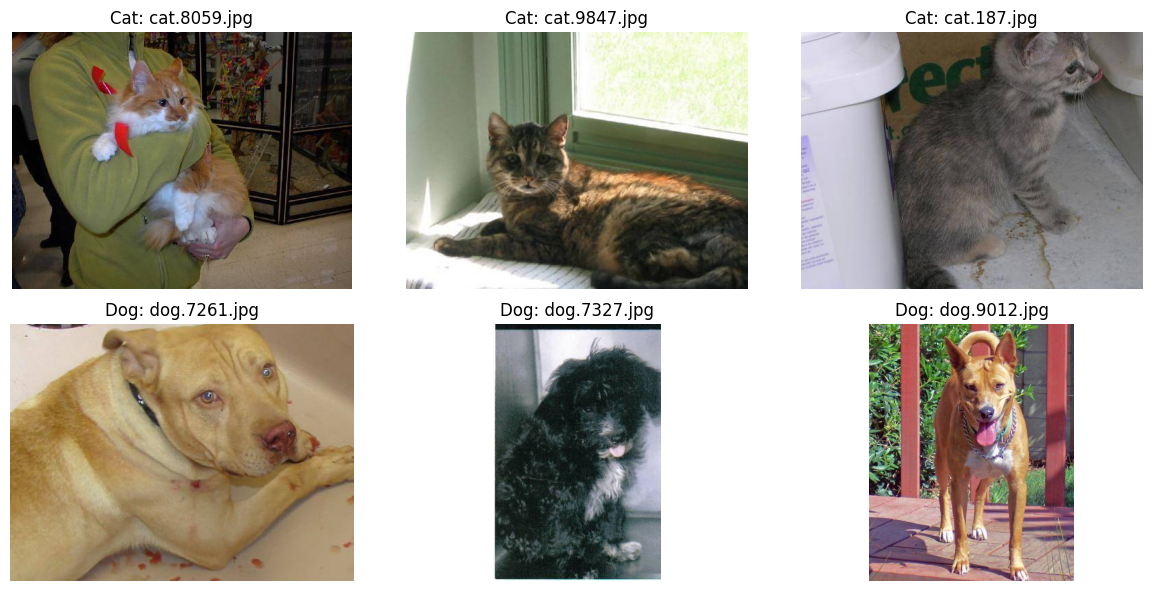

Number of cat images: 12500
Number of dog images: 12500


In [3]:
# Step 5: Display sample images from 'cat' and 'dog' folders
cat_images = os.listdir(cat_dir)[:3]
dog_images = os.listdir(dog_dir)[:3]

plt.figure(figsize=(12, 6))

# Plot cat images
for i, img_name in enumerate(cat_images):
    img_path = os.path.join(cat_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Cat: {img_name}")
    plt.axis('off')

# Plot dog images
for i, img_name in enumerate(dog_images):
    img_path = os.path.join(dog_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(f"Dog: {img_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Step 6: Confirm number of images
print(f"Number of cat images: {len(os.listdir(cat_dir))}")
print(f"Number of dog images: {len(os.listdir(dog_dir))}")

#### Step 1: Extract features using ResNet50 + XGBoost classification

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import models
from collections import Counter
from tqdm import tqdm
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=train_extract_path, transform=transform)

# === [1] Split Dataset ===
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Train:", Counter([label for _, label in train_ds]))
print("Val:", Counter([label for _, label in val_ds]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === [2] Load ResNet50 & Modify Final Layer ===
model = models.resnet50(pretrained=True)
model.fc = nn.Identity()  # Remove classification head
model.to(device)
model.eval()

# === [3] Feature Extraction ===
def extract_features(data_loader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_val, y_val = extract_features(val_loader)

Train: Counter({1: 10010, 0: 9990})
Val: Counter({0: 2510, 1: 2490})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.7MB/s]
Extracting features: 100%|██████████| 157/157 [00:21<00:00,  7.40it/s]


#### Step 2: Train XGBoost

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train)

y_prob = xgb_clf.predict_proba(X_val)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Log Loss: {log_loss(y_val, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['cat', 'dog']))

Validation Accuracy: 0.9800
Log Loss: 0.0642

Classification Report:
              precision    recall  f1-score   support

         cat       0.98      0.98      0.98      2510
         dog       0.98      0.98      0.98      2490

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



#### Step 3: Extract testing features for XGBoost

In [6]:
import os
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

# Define test folder
test_folder = "/kaggle/working/test/test"

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Ensure test images are processed in correct order
test_filenames = sorted(
    [f for f in os.listdir(test_folder) if f.endswith(".jpg")],
    key=lambda x: int(x.split(".")[0])
)

# Extract test features
def extract_test_features(filenames):
    model.eval()
    features = []
    image_ids = []
    with torch.no_grad():
        for fname in tqdm(filenames, desc="Extracting test features"):
            img_path = os.path.join(test_folder, fname)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)
            output = model(img)
            features.append(output.cpu().numpy().flatten())
            image_ids.append(int(fname.split(".")[0]))
    return np.array(features), image_ids

X_test, test_ids = extract_test_features(test_filenames)


Extracting test features: 100%|██████████| 12500/12500 [02:00<00:00, 103.74it/s]


In [7]:
y_test_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probability of class '1' (dog)

In [ ]:
import pandas as pd

# `test_ids` must already be defined from earlier feature extraction (e.g., from extract_test_features)

submission_df = pd.DataFrame({
    "id": test_ids,
    "label": y_test_proba
})

# Ensure the rows are sorted by image ID
submission_df = submission_df.sort_values("id").reset_index(drop=True)

# Save to CSV
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"✅ Submission saved to {submission_path}")
